<a href="https://colab.research.google.com/github/AybarsCebi/CS412-Machine-Learning-Course-Sabanci-University/blob/main/CS412_Project_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import random_split
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
import torch
from tqdm import tqdm

from torch.utils.data import DataLoader
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

# Temel boyut ve sütun bilgisi
print("Shape of the dataset (Row, Column):", df.shape)
print("Sütunlar:", df.columns.tolist())

# Eksik değer kontrolü
print("\nNumber of null Values on columns:")
print(df.isnull().sum())

# Sınıf dağılımı
print("\nClass Distribution:")
print(df['sentiment'].value_counts())

# İnceleme uzunluklarını hesapla
df['char_count'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().apply(len)

# Karakter ve kelime sayısı için tanımlayıcı istatistikler
print("\nKarakter ve kelime sayısı tanımlayıcı istatistikleri:")
print(df[['char_count', 'word_count']].describe())

Shape of the dataset (Row, Column): (50000, 2)
Sütunlar: ['review', 'sentiment']

Number of null Values on columns:
review       0
sentiment    0
dtype: int64

Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Karakter ve kelime sayısı tanımlayıcı istatistikleri:
         char_count    word_count
count  50000.000000  50000.000000
mean    1309.431020    231.156940
std      989.728014    171.343997
min       32.000000      4.000000
25%      699.000000    126.000000
50%      970.000000    173.000000
75%     1590.250000    280.000000
max    13704.000000   2470.000000


In [ ]:
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
max_len = 256
reviews = df['review'].tolist()

encodings = tokenizer(
    reviews,
    add_special_tokens=True,
    max_length=max_len,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
label_map = {'negative': 0, 'positive': 1}
labels = torch.tensor(df['sentiment'].map(label_map).values)

class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

dataset = IMDBDataset(encodings, labels)

print("input_ids shape:", encodings['input_ids'].shape)
print("attention_mask shape:", encodings['attention_mask'].shape)

print("token_type_ids shape:", encodings['token_type_ids'].shape if 'token_type_ids' in encodings else "Yok")
print("\nİlk örnek veri yapısı:", dataset[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

input_ids shape: torch.Size([50000, 256])
attention_mask shape: torch.Size([50000, 256])
token_type_ids shape: Yok

İlk örnek veri yapısı: {'input_ids': tensor([    0,  3762,     9,     5,    97, 34910,    34,  2801,    14,    71,
         2494,    95,   112, 10548,  3238,    47,   581,    28, 18954,     4,
          252,    32,   235,     6,    25,    42,    16,  2230,    99,  1102,
           19,   162, 49069,  3809,  1589, 49007,  3809, 48709,   133,    78,
          631,    14,  2322,   162,    59, 10548,    21,    63, 20509,     8,
        29747,  3796,   154,  5422,     9,  1476,     6,    61,   278,    11,
          235,    31,     5,  2136, 11932,     4,  3101,   162,     6,    42,
           16,    45,    10,   311,    13,     5, 27922,  1144,   196,    50,
        39649,     4,   152,   311, 16427,   117, 19594,    19, 11246,     7,
         2196,     6,  2099,    50,  1476,     4,  3139,    16, 27482,     6,
           11,     5,  4187,   304,     9,     5,  2136, 49069,  38

In [ ]:
!pip install transformers

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

first_batch = next(iter(train_loader))
print(first_batch['input_ids'].shape)
print(first_batch['labels'].shape)

torch.Size([16, 256])
torch.Size([16])


In [ ]:
from transformers import RobertaForSequenceClassification
from sklearn.metrics import accuracy_score
import pandas as pd
import torch
from transformers import get_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(lr, weight_decay=0.01, num_epochs=1):
    # 1) Modeli hazırla
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base', num_labels=2
    ).to(device)

    # 2) Optimizer ve scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    # 3) Eğitim döngüsü
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].long().to(device)

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    # 4) Doğrulama (validation)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].long().to(device)

            logits = model(**inputs).logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return accuracy_score(all_labels, all_preds)

# ----- Grid Search: Sadece learning rate -----
lr_list = [1e-5, 2e-5, 3e-5, 5e-5]
fixed_wd = 0.01
num_epochs = 1   # ihtiyaca göre artırılabilir

best_acc = 0.0
best_lr = None
results = []

for lr in lr_list:
    acc = evaluate_model(lr, fixed_wd, num_epochs=num_epochs)
    results.append((lr, acc))
    print(f"lr={lr:.0e} --> val_acc={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_lr = lr

print(f"\nEn iyi validation accuracy: {best_acc:.4f} (lr={best_lr:.0e})")

# Sonuçları DataFrame ile göster
df_grid = pd.DataFrame(results, columns=['learning_rate', 'val_accuracy'])
df_grid = df_grid.sort_values('val_accuracy', ascending=False).reset_index(drop=True)
print("\nGrid Search Results:")
print(df_grid)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr=1e-05 --> val_acc=0.9440


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr=2e-05 --> val_acc=0.9406


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr=3e-05 --> val_acc=0.9402


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr=5e-05 --> val_acc=0.9380

En iyi validation accuracy: 0.9440 (lr=1e-05)

Grid Search Results:
   learning_rate  val_accuracy
0        0.00001        0.9440
1        0.00002        0.9406
2        0.00003        0.9402
3        0.00005        0.9380


Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/4: 100%|██████████| 1250/1250 [06:02<00:00,  3.45it/s]


Epoch 1: Train Loss=0.2682, Train Acc=0.8720


Validation Loss=0.1658, Validation Acc=0.9400


Epoch 2/4: 100%|██████████| 1250/1250 [06:01<00:00,  3.45it/s]


Epoch 2: Train Loss=0.1396, Train Acc=0.9477


Validation Loss=0.1523, Validation Acc=0.9442


Epoch 3/4: 100%|██████████| 1250/1250 [06:01<00:00,  3.45it/s]


Epoch 3: Train Loss=0.0960, Train Acc=0.9667


Validation Loss=0.1682, Validation Acc=0.9494


Epoch 4/4: 100%|██████████| 1250/1250 [06:02<00:00,  3.45it/s]


Epoch 4: Train Loss=0.0643, Train Acc=0.9795


Validation Loss=0.1857, Validation Acc=0.9480
Classification Report:
               precision    recall  f1-score   support

           0     0.9504    0.9381    0.9442      2535
           1     0.9371    0.9497    0.9434      2465

    accuracy                         0.9438      5000
   macro avg     0.9438    0.9439    0.9438      5000
weighted avg     0.9439    0.9438    0.9438      5000



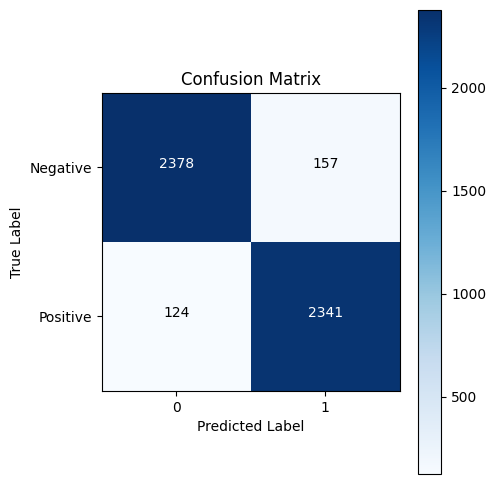

ROC AUC Score: 0.9853634512364425
Test Accuracy : 0.9438
Test Precision: 0.9371
Test Recall   : 0.9497
Test F1-Score : 0.9434


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import get_scheduler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2
)
model.to(device)


# 2. DataLoader İyileştirmeleri
batch_size = 32  # Performans-tradeoff; büyük batch GPU verimliliğini artırır, küçük batch bellek sınırlarına uyar
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True  # num_workers ve pin_memory GPU transferlerini hızlandırır
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

# 3. Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # weight_decay ile aşırı uyumu (overfitting) azaltır
num_epochs = 4
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),  # Warm-up: ilk %10 adımda learning rate artışı
    num_training_steps=num_training_steps
)

# 4. Kayıp Fonksiyonu
loss_fn = torch.nn.CrossEntropyLoss()

# 5. Eğitim Döngüsü
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in progress:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    print(f"\nEpoch {epoch+1}: Train Loss={avg_loss:.4f}, Train Acc={train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    print(f"Validation Loss={avg_val_loss:.4f}, Validation Acc={val_acc:.4f}")

# 6. Test Aşaması ve Metrikler
model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)[:, 1]

        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Performans metrikleri
print("Classification Report:\n", classification_report(all_labels, all_preds, digits=4))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()

print("ROC AUC Score:", roc_auc_score(all_labels, all_probs))

accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)
print(f"Test Accuracy : {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall   : {recall:.4f}")
print(f"Test F1-Score : {f1:.4f}")
